# 6.6 Sourcing & Analyzing Time-Series Data & Forecasting with ARIMA in Python

### 1. Importing libraries and data
##### Data source: https://data.nasdaq.com/data/UMICH-consumer-sentiment
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the "Index of Consumer Sentiment" Data
### 6. Forecasting with ARIMA in Python
#### 6.1 Defining Your Parameters
#### 6.2 Splitting the Data
#### 6.3 Running and Fitting the Model
#### 6.4 Iterating

# 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [2]:
# Configuring API key
quandl.ApiConfig.api_key = 'cJ9xoBP3fyKzFdsv3zCx'

In [3]:
# Importing the University of Michigan Consumer Survey "Index of Consumer" Sentiment variable.
data = quandl.get('UMICH/SOC1')

In [4]:
# Defining a path
path = r'C:\Users\franc\OneDrive\Desktop\DA\python'

In [5]:
# Importing the dataset
df = pd.read_csv(os.path.join(path,'UMICH-SOC1.csv'), index_col = False)

In [6]:
# Getting info about the data sets
df.shape

(634, 2)

In [7]:
df.head()

,Date,Index
0,2023-02-28,67.0
1,2023-01-31,64.9
2,2022-12-31,59.7
3,2022-11-30,56.8
4,2022-10-31,59.9


In [8]:
df.columns

Index(['Date', 'Index'], dtype='object')

In [9]:
df.dtypes

Date      object
Index    float64
dtype: object

In [10]:
# Converting "date" datatype from object to datetime
df['Date']=pd.to_datetime(df['Date'], infer_datetime_format=True)

# 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Resetting index in order to use the "Date" column as a filter
df2 = data.reset_index()

In [12]:
# Getting info about the data sets
df2.shape

(634, 2)

In [13]:
df2.head(10)

,Date,Index
0,1952-11-30,86.2
1,1953-02-28,90.7
2,1953-08-31,80.8
3,1953-11-30,80.7
4,1954-02-28,82.0
5,1954-05-31,82.9
6,1954-11-30,87.0
7,1955-02-28,95.9
8,1955-05-31,99.1
9,1955-11-30,99.7


In [14]:
df2.tail(5)

,Date,Index
629,2022-10-31,59.9
630,2022-11-30,56.8
631,2022-12-31,59.7
632,2023-01-31,64.9
633,2023-02-28,67.0


The data set is a collection of information from 1952 until 2023. Since it is a very wide range, I decided to create a subset that covers data from 1985 to the present and would result in a more legible visualization.

In [15]:
# Creating a subset to only show data from 1985
df_sub = df2.loc[(df2['Date'] >= '1985-01-01') & (df2['Date'] < '2023-02-28')]

In [16]:
df_sub.shape

(457, 2)

In [17]:
df_sub.head()

,Date,Index
176,1985-01-31,96.0
177,1985-02-28,93.7
178,1985-03-31,93.7
179,1985-04-30,94.6
180,1985-05-31,91.8


Our data set 

In [18]:
# Setting the "Date" column as the index
from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Creating a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Setting the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Dropping the "Date" column.

In [19]:
df_sub.head()

,Index
datetime,
1985-01-31,96.0
1985-02-28,93.7
1985-03-31,93.7
1985-04-30,94.6
1985-05-31,91.8


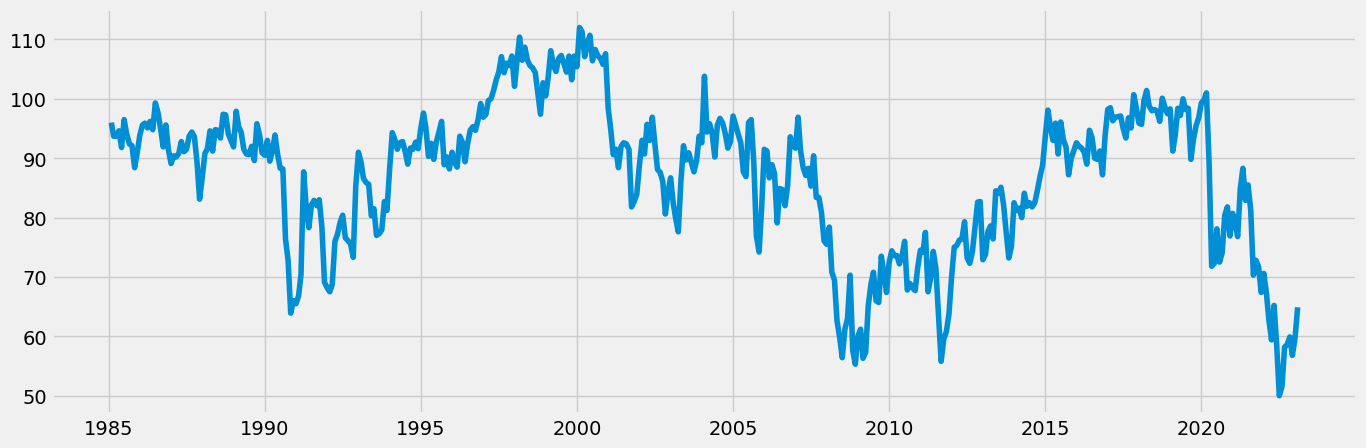

In [20]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [21]:
# Checking for missing values
df_sub.isnull().sum() #No missing values found

Index    0
dtype: int64

In [22]:
# Checking for duplicates
dups = df_sub.duplicated()
dups.sum() 

183

In [23]:
# Dropping the duplicate values
df_sub_no_dups = df_sub.drop_duplicates()

In [24]:
df_sub_no_dups.shape

(274, 1)

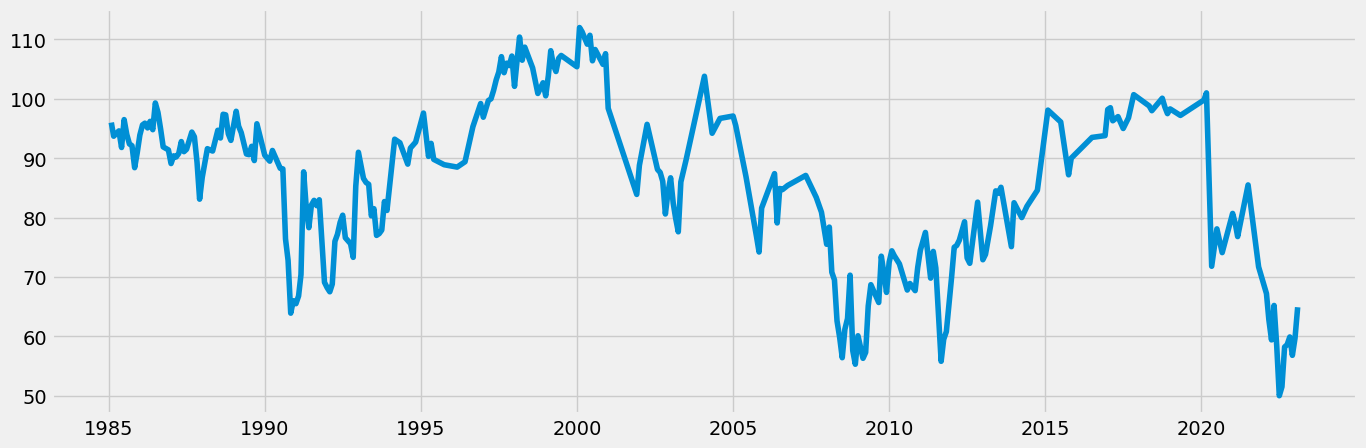

In [25]:
# Plotting the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub_no_dups)

# 3. Time series analysis: decomposition

In [26]:
# Decomposing the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

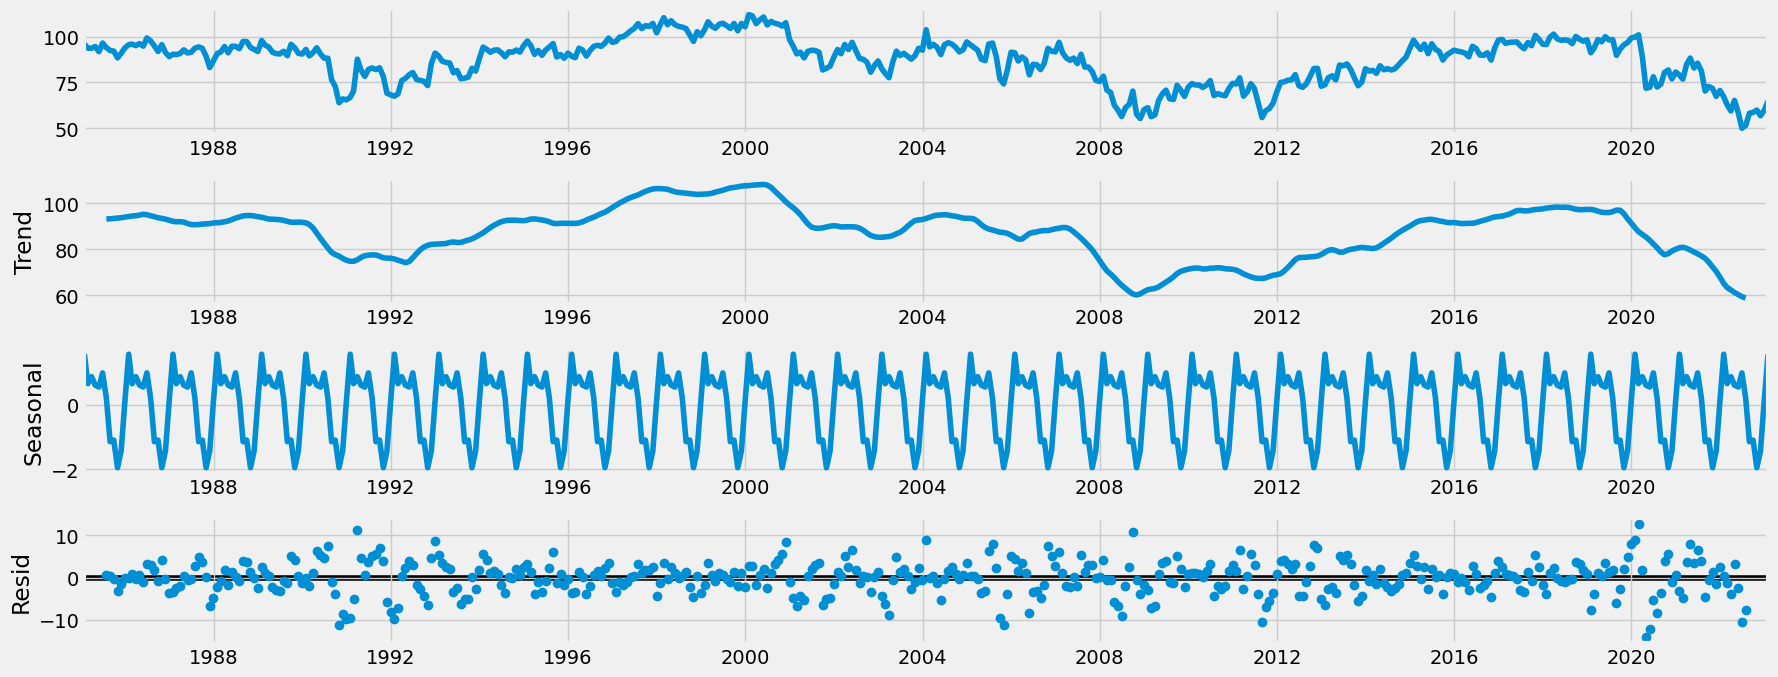

In [28]:
# Plotting the separate components
decomposition.plot()
plt.show()

The first chart in the graph above represents the data (with all of its components). It is known as the level.

The second reveals some underlying patterns. The trend shown in the graph displays plenty of ups and downs, including a peak in 2000 and a decrease in 2009, which may have been brought on by the global financial crisis. After 2009, we see another upward trend until 2020, when the pandemic may have caused another downward trend.

Seasonality is the third factor. Seasonal variations are illustrated here by a spikey curve that varies at regular intervals.

Finally, there's the noise—or, as it's referred to, "residual." As we can see, there is a lot of noise.

# 4. Testing for stationarity

In [29]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Index'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.035282
p-value                          0.271320
Number of Lags Used              5.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In this case, we're using a significance level of 5%. The “Critical Value (5%)” in our results has a value of -2.86. This is smaller than the test statistic, which is -2.035, which means that there is a unit root in our data and that it is non-stationary.

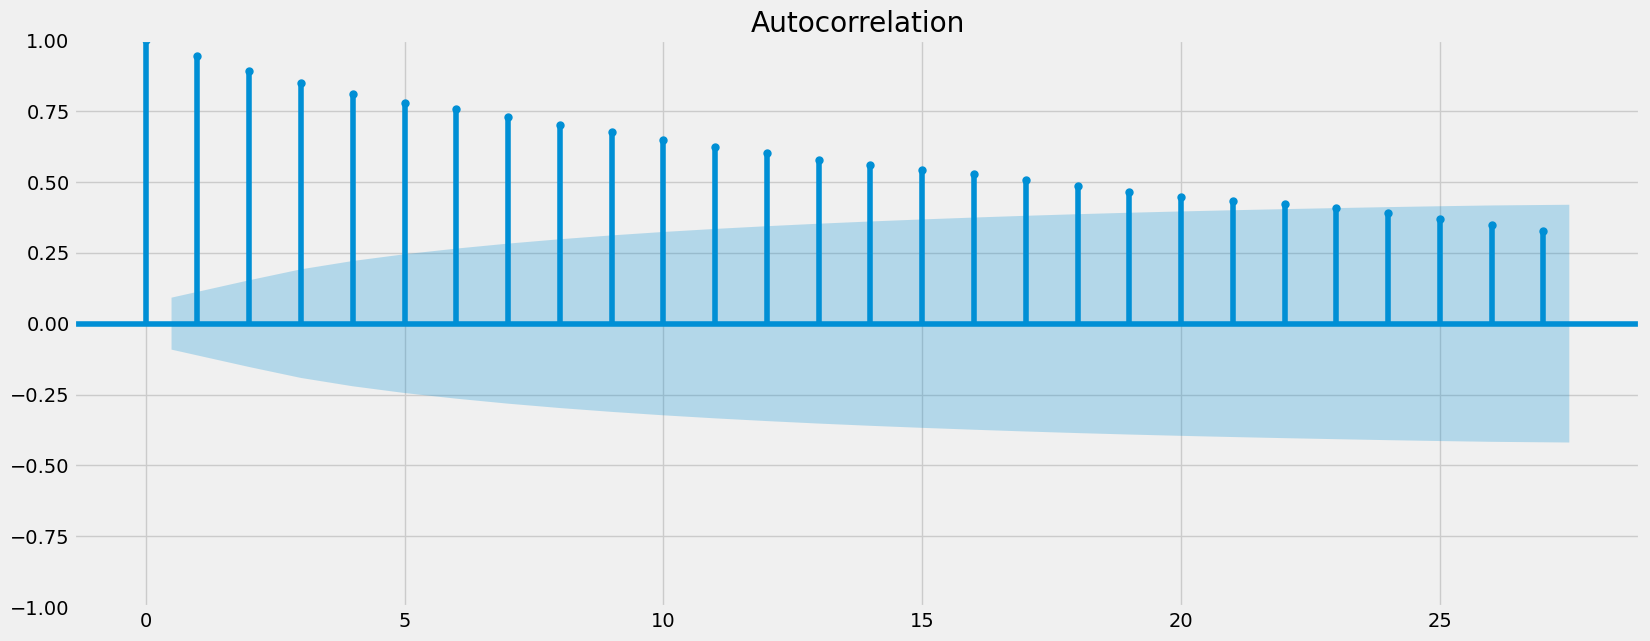

In [30]:
# Checking out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub)
plt.show()

There are multiple lags that are connected with one another, and the lines exceed the blue border of the confidence interval, suggesting that the data is non-stationary.

# 5. Stationarizing the "Index of Consumer Sentiment" Data

In [31]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [32]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 

In [33]:
data_diff

,Index
datetime,
1985-02-28,-2.3
1985-03-31,0.0
1985-04-30,0.9
1985-05-31,-2.8
1985-06-30,4.7
...,...
2022-09-30,0.4
2022-10-31,1.3
2022-11-30,-3.1


In [34]:
data_diff.columns

Index(['Index'], dtype='object')

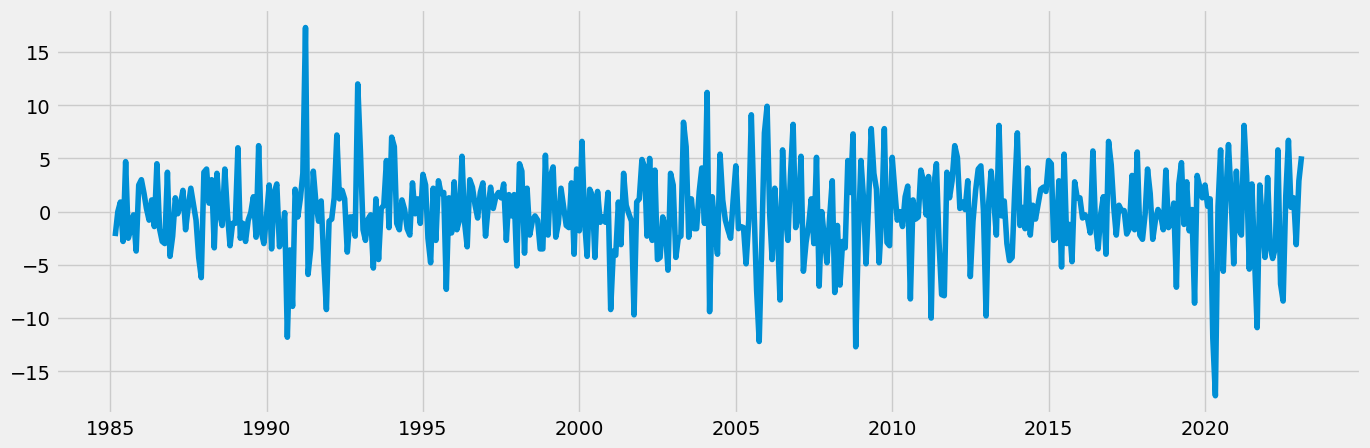

In [35]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.231883e+01
p-value                        6.824065e-23
Number of Lags Used            4.000000e+00
Number of Observations Used    4.510000e+02
Critical Value (1%)           -3.444933e+00
Critical Value (5%)           -2.867970e+00
Critical Value (10%)          -2.570195e+00
dtype: float64


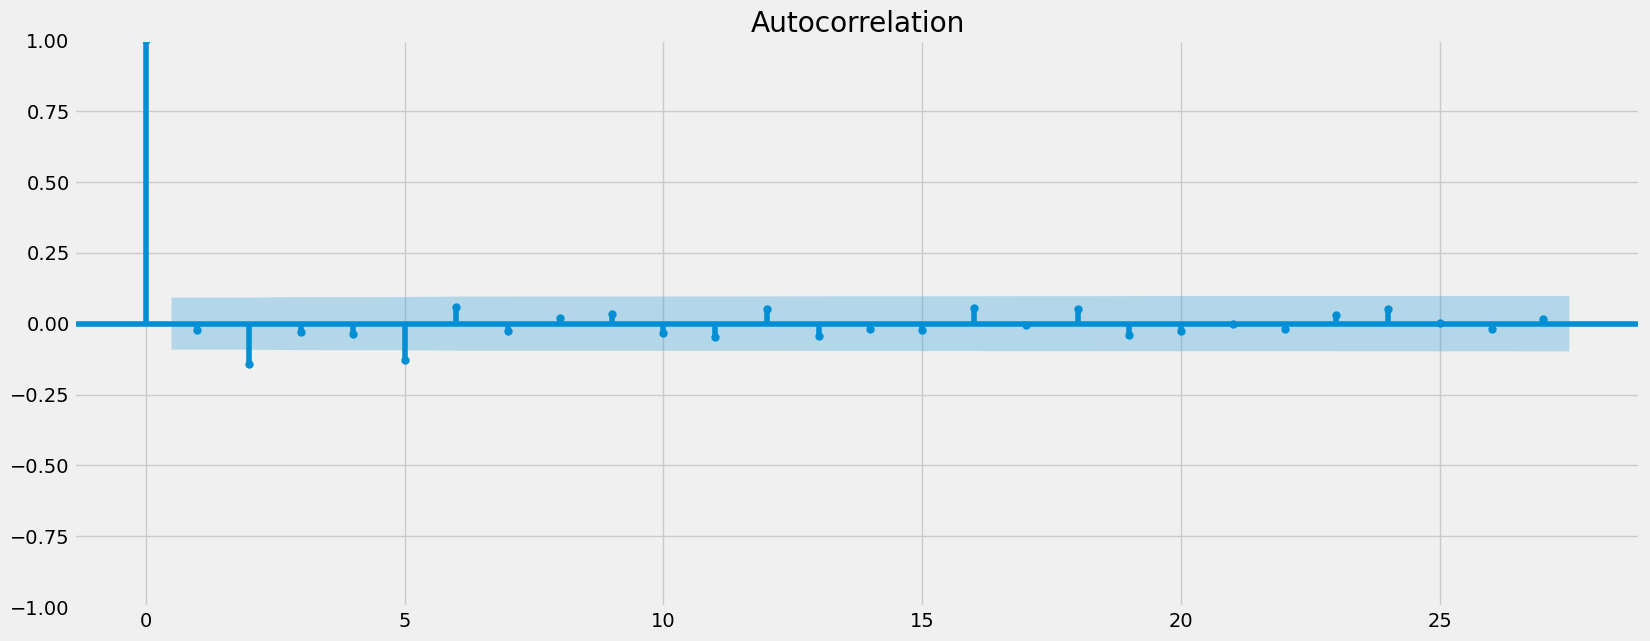

In [37]:
plot_acf(data_diff)
plt.show()

This time, the test statistic for the Dickey-Fuller test is smaller than the critical values, and there is just one lag over the confidence interval on the autocorrelation graph. These findings indicate that the data is now stationary.

# 6. Forecasting with ARIMA in Python

## 6.1 Defining Your parameters

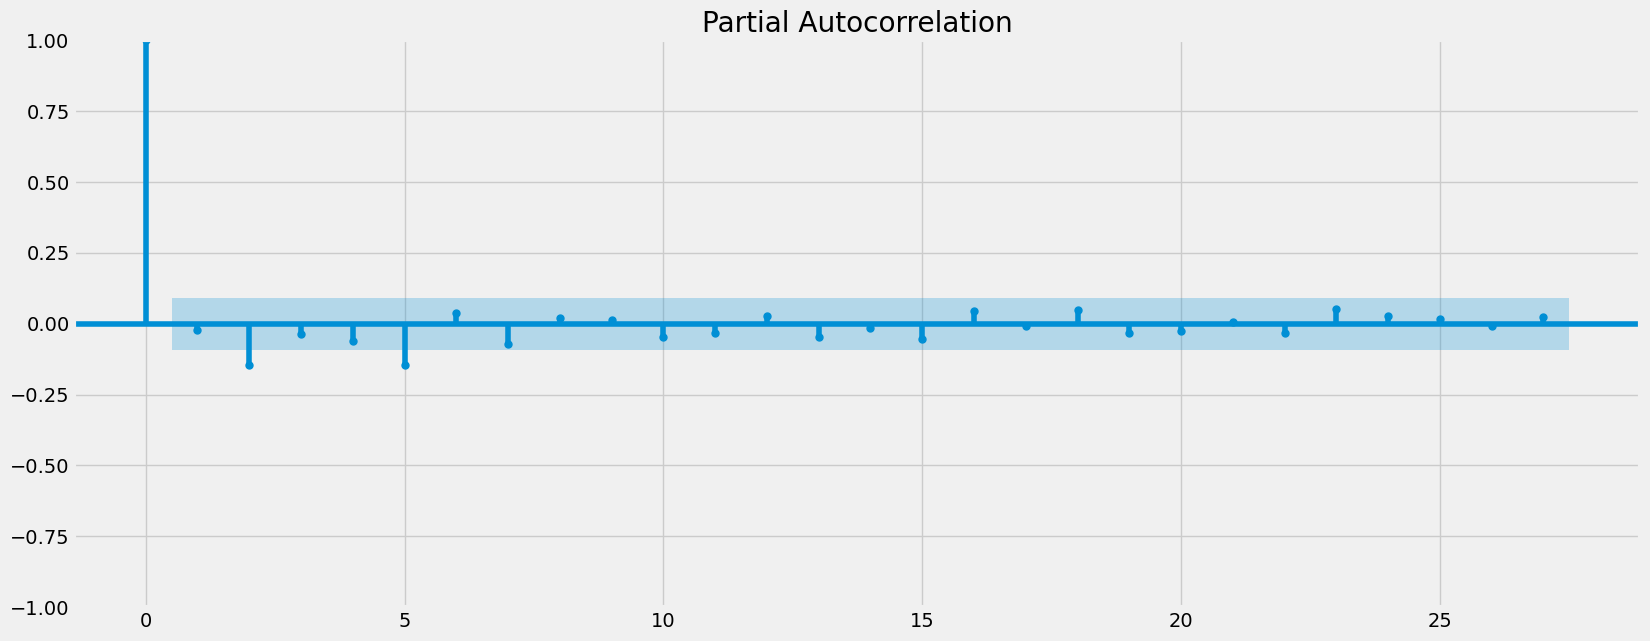

<Figure size 4500x4500 with 0 Axes>

In [38]:
# Plotting partial autocorrelations to determine parameter p
plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

In the figure above, we can notice that there are some slighty higher positive bars. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

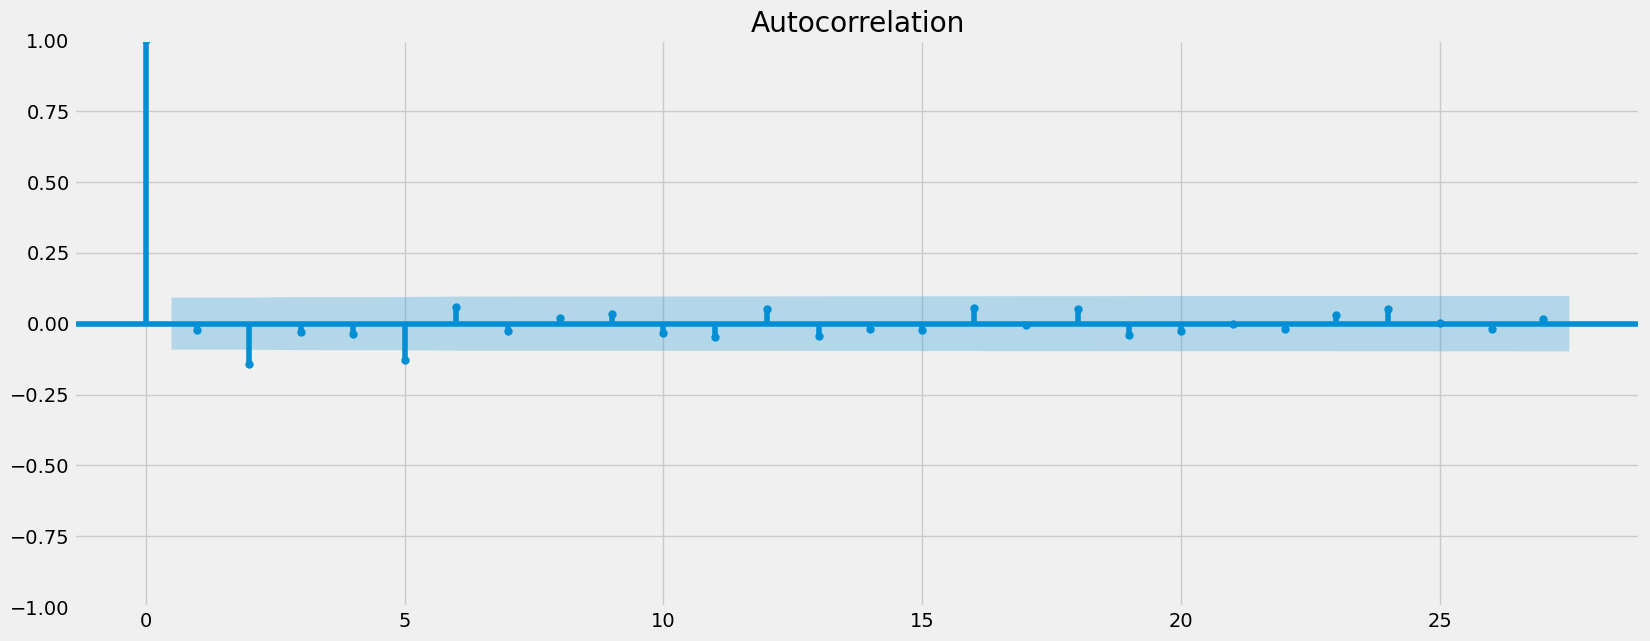

In [39]:
# Plotting autocorrelations to determine parameter q
plot_acf(data_diff)
plt.show()

In the visualization above there are not significant autocorrelations. Let's take a conservative approach and see what the output is like at q = 3.

# 6.2 Splitting the data

In [40]:
# Splitting the Data
train = data_diff[data_diff.index <= '2010-01-01'] 
test = data_diff[data_diff.index >= '2010-01-01']

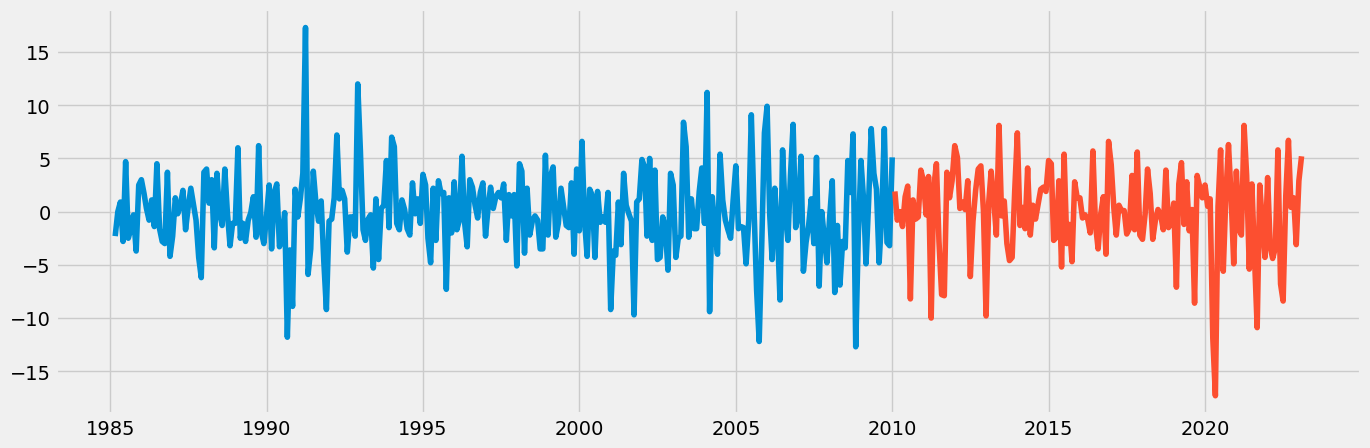

In [41]:
# Plotting both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [42]:
test.shape

(157, 1)

## 6.3 Running and Fitting the model

In [43]:
# Importing the model needed
from statsmodels.tsa.api import ARIMA

In [44]:
# Checking model summary
model = ARIMA(train, order=(5, 1, 3))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Index   No. Observations:                  299
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -828.038
Date:                Tue, 18 Apr 2023   AIC                           1674.075
Time:                        14:50:07   BIC                           1707.349
Sample:                    02-28-1985   HQIC                          1687.395
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0175      0.266     -3.823      0.000      -1.539      -0.496
ar.L2         -0.7161      0.306     -2.340      0.019      -1.316      -0.116
ar.L3         -0.2054      0.095     -2.172      0.0

In [45]:
# Forecasting
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

In [46]:
# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

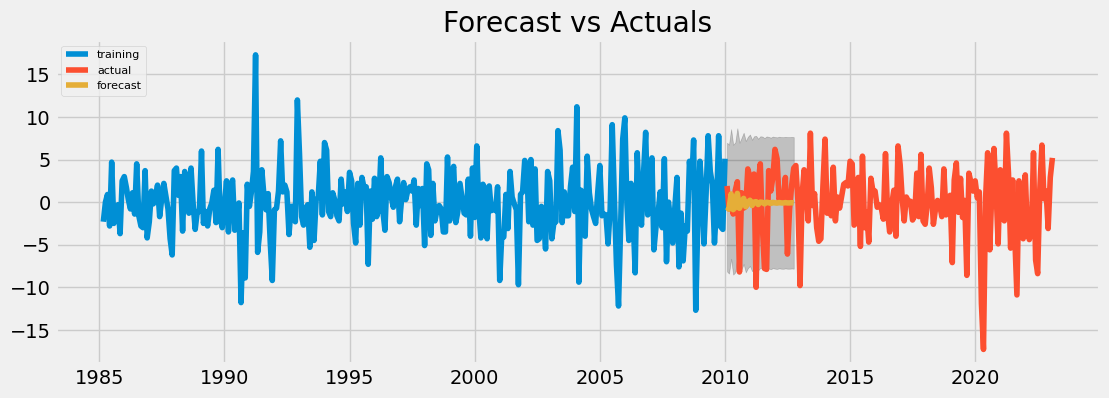

In [47]:
# Plotting
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 6.4 Iterating

                               SARIMAX Results                                
Dep. Variable:                  Index   No. Observations:                  299
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -832.074
Date:                Tue, 18 Apr 2023   AIC                           1674.149
Time:                        14:50:07   BIC                           1692.634
Sample:                    02-28-1985   HQIC                          1681.548
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0533      0.053     -0.999      0.318      -0.158       0.051
ar.L2         -0.1076      0.062     -1.744      0.081      -0.229       0.013
ar.L3         -0.0563      0.057     -0.997      0.3

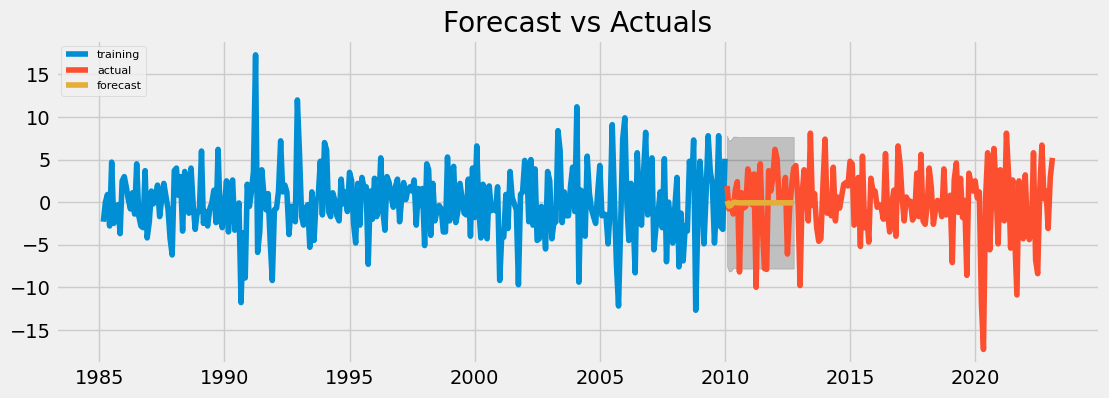

In [48]:
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecasting
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

# Making into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

# Plotting
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Index   No. Observations:                  299
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -833.497
Date:                Tue, 18 Apr 2023   AIC                           1674.994
Time:                        14:50:08   BIC                           1689.782
Sample:                    02-28-1985   HQIC                          1680.914
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9531      0.089    -10.658      0.000      -1.128      -0.778
ma.L1         -0.0706      0.748     -0.094      0.925      -1.536       1.395
ma.L2         -0.9291      0.668     -1.390      0.1

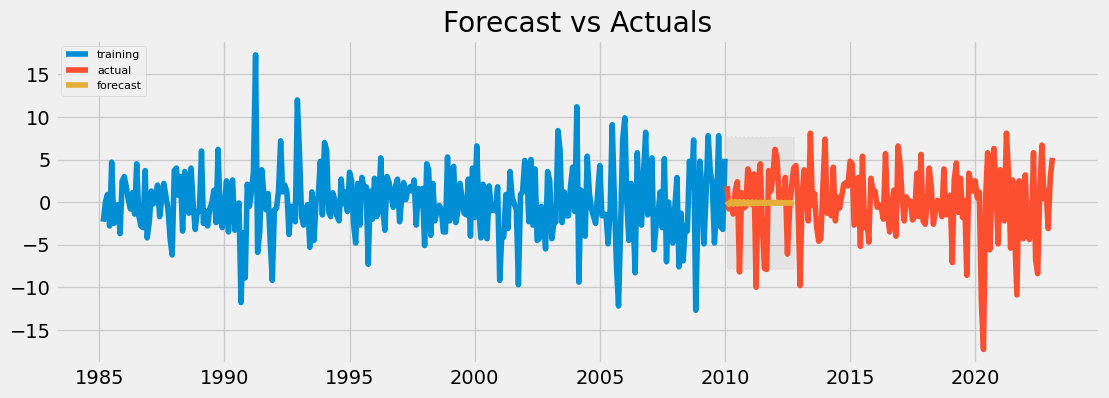

In [49]:
# Trying another iteration where AR ( p ) is reduced to 1
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecasting
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()